# Proyecto aplicado: "Pokemon_data"
* Andrés Forero
* Daniel Cuellar
* Daniela González 




## Librerías 
______

In [ ]:
from builtins import len

# manejo de data
import pandas as pd
import numpy as np
import math
from scipy import stats
# visualización
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

In [ ]:
sns.set_context("paper")
sns.set_style("whitegrid")

# Metodología CRISP-DM
___
<img src="http://www.iic.uam.es/wp-content/uploads/2021/11/CRISP-DM.jpg" width="400" height="400" />


## Situación actual


## Descripción del dataset
_______________


## Problema
_____


## Objetivos
_____

### General


### Específico 



## Hipótesis (científica o estadística)
------


# Entendimiento de los datos
----

## Carga De Datos


In [ ]:
data = pd.read_csv("pokemon.csv")

## Describir los datos 


Este conjunto de datos contiene información sobre los 802 Pokémon de las Siete Generaciones de Pokémon, y el cual contiene las siguientes características.


* Name: El nombre en inglés del Pokémon.
* Japanese_name: El nombre japonés original del Pokémon
* Pokedex_number: El número de entrada del Pokémon en el Pokédex Nacional
* Percent_male: El porcentaje de las especies que son machos. En blanco si el Pokémon no tiene género.
* Type1: El tipo primario del Pokémon
* Type2: El tipo secundario del Pokémon
* Clasificación: La clasificación de los Pokémon como se describe en el Sol y la Luna Pokédex
* Height_m: Altura del Pokémon en metros
* Weight_kg: El Peso del Pokémon en kilogramos
* Capture_rate: Tasa de captura del Pokémon
* Base_egg_steps: La cantidad de pasos necesarios para eclosionar un huevo del Pokémon
* Abilities:Lista ordenada de habilidades que el Pokémon es capaz de tener.
* Experience_growth: Cantidad de puntos que obtiene un Pokémon al derrotar a otro en un combate y subir de nivel
* Base_happiness: Felicidad Base del Pokémon
* Against_?: Dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
* Base_total:Suma de las características del pokémon "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"
* HP: (Health Points) condición fisica del Pokémon, representada con un valor numérico
* Attack:El Ataque Base de los Pokémon
* Defense:La Defensa Base de los Pokémon
* Sp_attack: El Ataque Especial Base del Pokémon
* Sp_defense: La Defensa Especial Base del Pokémon
* Speed:La velocidad base del Pokémon
* Generation: Generación numerada en la que se introdujo por primera vez el Pokémon
* Is_legendary:Indica si el Pokémon es legendario.

In [ ]:
data.info()

In [ ]:
data.head()

## Limpieza de datos

Se valida que la variable "base_total" esta compuesta por la suma de las características "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"

In [ ]:
prueba_base=data['attack']+data['defense']+data['hp']+data['sp_attack']+data['sp_defense']+data['speed']
comparacion=prueba_base==data['base_total']
comparacion.sum()

### Valores nulos

In [ ]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

Dado que hay solo 20 faltantes para height_m y weight_kg, se decide buscar la información faltante en una base externa [Pokédex](https://www.pokemon.com/el/pokedex).

In [ ]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")

data_missing.rename(columns={"weight_km":"weight_kg"})

In [ ]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")
data_missing.rename(columns={"weight_km":"weight_kg"})
df2=pd.merge(data_missing, data, on="name")
df2=df2.drop(["height_m_y", "weight_kg_y"], axis=1)
df2=df2.rename(columns={"weight_kg_x":"weight_kg", "height_m_x": "height_m"})
data_fix=data[data["weight_kg"].notna() ]
data_fix
a=data_fix.columns.tolist()
df2=df2[a]
data = pd.concat([data_fix,df2], axis=0)

In [ ]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

### Sexo del pokémon

Se crea una columna adicional para el porcentaje de sexo femenino, por ende, para los pokemón que no poseen sexo, se dejan en 0 las 2 columnas de sexo.

In [ ]:
data["percentage_female"]= [ 0 if pd.isna(i) else 100-i for i in data.percentage_male]
data["percentage_male"]=data["percentage_male"].fillna(0)

### Ajuste de tasa de captura

In [ ]:
data.capture_rate.unique()

In [ ]:
data.loc[data.capture_rate=='30 (Meteorite)255 (Core)',"capture_rate"]=30

data['capture_rate'] = data['capture_rate'].astype(int)

### Descarte de variables

Se descartan las siguientes variables:
* abilitites: están fuera del alcance.
* classfication: no provee mucha información.
* japanese_name: se va a trabajar con el nombre en inglés "name".
* pokedex_number: al ser un índice no da información adicional.
* type2: la mayoría de registros son de 1 solo tipo por ende se deja fuera del alcance.

In [ ]:
datos = data.loc[:,~data.columns.isin(["abilities","classfication","japanese_name","pokedex_number","type2"])]

## Estadística exploratoria
------

In [ ]:
categorical_data = data.select_dtypes(include=['object']).columns
def est_exploratoria(data,categoricas):
    """
    tablas de estadística exploratoria
    ---
    data : dataframe
    categoricas : lista con nombre de variables a tratar como categoricas
    
    """
    datos = data.loc[:,~data.columns.isin(categoricas)]

    df0 = datos.agg([lambda x : sum(x.isna()),"count",]).rename(index={"<lambda>": 'Na count'})
    df1 = datos.agg(["mean"])
    df2 = datos.agg(pd.Series.mode).loc[[0]].rename(index={0: 'mode'})
    df3 = datos.agg(["median","std","var","kurt","skew","max","min"])

    df = pd.concat([df0,df1,df2, df3])

    df["Measurement"] = df.index
    df["Type"]=["Structure","Structure","Central t.","Central t.","Central t.","Dispersion","Dispersion","Shape","Shape","Range","Range"]
    df.set_index("Type", append=False, inplace=True)
    df.set_index("Measurement", append=True, inplace=True)

    numerica=df.round(decimals=2)

    datos = data.loc[:,data.columns.isin(categoricas)]


    df0 = datos.agg([lambda x : sum(x.isna())]).rename(index={"<lambda>": 'Na count'})

    df = pd.concat([df0,datos.describe(include=['object',"string"])])

    categorica=df.round(decimals=2)
    return numerica, categorica

numerica, categorica = est_exploratoria(datos,categorical_data)

numerica


In [ ]:
categorica

## Visualización de datos
------

In [ ]:
contras=datos[datos.columns[
    (pd.Series(datos.columns).str.startswith('against')) | 
    (datos.columns=="type1")]].groupby(["type1"]).agg("mean")

contras.head()


In [ ]:
import plotly.express as px
fig = px.imshow(contras,
                labels=dict(x="From", y="Type", color="Damage Received"),
                color_continuous_scale='Jet',title="Daño recibido según tipo de pokemón")
fig.update_layout(width=1000, height=900,template='plotly_white')
fig.show()

In [ ]:
combat_stats = ['attack','defense','hp','sp_attack', 'sp_defense','speed']
other_stats = ['height_m', 'weight_kg','capture_rate','base_egg_steps']

def plot_stats(datos,listado,titulo):
    n_rows=2
    n_cols=math.ceil(len(listado)/2)

    fig,ax = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(11,5))
    count=0
    palette = list(reversed(sns.color_palette("pastel", len(listado)).as_hex()))

    class salida(Exception): pass

    try: 
        for i in range(n_rows):
            for j in range(n_cols):
                # print(i,j)
                sns.histplot(datos[listado[count]], kde=True,color=palette[count],alpha=0.2,edgecolor="gray",ax=ax[i,j])
                # ax[i,j].hist(datos[listado[count]],color=palette[count])
                ax[i,j].axvline([datos[listado[count]].mean()],color="red",label=f"mean_{listado[count]}: {round(datos[listado[count]].mean(),2)}")
                ax[i,j].legend()
                ax[i,j].title.set_text(f'Hist {listado[count]}')

                count+=1
                if count==len(listado): raise salida

    except salida:
        None




    fig.suptitle(titulo, fontsize=16)
    fig.tight_layout()


plot_stats(datos,combat_stats,"Hist. estadísticas de combate")
plot_stats(datos,other_stats,"Hist. estadísticas varias")

In [ ]:
type1_counts = datos["type1"].value_counts().sort_values()
fig, ax = plt.subplots()
ax.barh(type1_counts.index, type1_counts.values, color='green')
ax.set_title("Conteo tipos de pokemón",fontsize=16)
ax.set_xlabel("Cantidad")
plt.show()


# DANIEL 
* Boxplot variables por tipo y legendario

In [ ]:
var_corr_1=['against_dark', 'attack', 'base_egg_steps', 'base_total', 'base_total', 'base_total']
var_corr_2=['against_ghost','base_total','is_legendary','capture_rate','sp_attack','sp_defense']
for i in range(len(var_corr_2)):
    fig= px.box(datos,y=var_corr_2[i], x="type1", color="is_legendary")
    fig.update_traces(quartilemethod="exclusive")
    fig.show()

In [ ]:

fig= px.box(datos,y="base_egg_steps", x="type1", color="is_legendary")
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [ ]:
var_corr_1=['against_dark', 'attack', 'base_egg_steps', 'base_total', 'base_total', 'base_total']
var_corr_2=['against_ghost','base_total','is_legendary','capture_rate','sp_attack','sp_defense']
for i in range(len(var_corr_2)):
    fig= px.scatter(datos,y=var_corr_2[i], x=var_corr_1[i],)
    fig.show()

## Filtros


Dados los diferentes alcances del proyecto se realizarán filtros para tener conjuntos de datos apropiados para los análisis posteriores.

No supervisado: 
* agrupar pokemones con características similares

Supervisados:
* clasificador el tipo de pokémon
* clasificador si es legendario


In [ ]:
datos = datos.loc[:,~datos.columns.isin(["name"])]

# Análisis de datos
___

## Pruebas de correlación



In [ ]:
data_corr = datos.select_dtypes(include=['int','float64'])

def tabla_corr_pearson(data_fixed,alfa,umbral):
  newdf = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
  result = []


  for i in newdf.columns:
    for j in newdf.columns:
      if i!=j:
        coef, p = stats.pearsonr(newdf[i], newdf[j])
        result.append([i,j,coef,p < alfa,p])

  correlaciones = pd.DataFrame(result,columns=["Var_i","Var_j","Coef_corr","Correlacionada","p_value"])


  return correlaciones[(correlaciones.Correlacionada==True) & (abs(correlaciones.Coef_corr)>=umbral)].drop_duplicates(["Coef_corr","p_value"])


tabla_corr_pearson(data_corr,0.05,0.65)

___

___

___

# 3 Transforme las variables categóricas y continuas en variables que entienda el modelo de predicción.

Recuerde tener en cuenta si las variables son categóricas (nominales, ordinales) o numéricas (discretas, continuas).

https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d

- TargetEncoding
- LabelEncoding
- OneHotEncoding
- CategoricalEncoding


In [ ]:
datos.info()

In [ ]:
cat_one_hot= ["type1","generation"]
num_scaler = datos.select_dtypes(include=['int64',"float64"]).columns
num_scaler.drop("is_legendary")

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_data", MinMaxScaler(), num_scaler),
        ("categorical_data", OneHotEncoder(handle_unknown="ignore"), cat_one_hot),
    ]
)
preprocessor

In [ ]:
a=preprocessor.fit_transform(datos)
a=pd.DataFrame(a)

a.columns=preprocessor.fit(datos).get_feature_names_out()
a.head()


In [ ]:
a.describe()

In [ ]:

preprocessor.fit_transform(datos)

def graf_pca(datos,limite=0.95,add_title=""):
    """
    datos: data a probar por pca
    limite: cuánta varianza quiere ser explicada
    add_title: parte para añadir al titulo
    """
    pca = PCA() 
    transf = pca.fit_transform(datos)
    
    varianza_expl = pca.explained_variance_ratio_

    var_cum=np.column_stack((range(0,len(varianza_expl)),varianza_expl.cumsum()))

    # limite=0.95
    punto=np.argmin(np.abs(np.array(var_cum[:,1])-limite))


    plt.plot(var_cum[:,0],var_cum[:,1] , '--r')
    plt.axhline(y=limite, color='b')
    plt.title("Explicación de varianza acumulada por N componentes" + add_title)
    plt.xlabel("N componentes")
    plt.xlabel("Varianza acumulada explicada")
    plt.annotate('Comp. cercano al %.2f  = (%.0f, %.4f)'%(limite,punto, var_cum[punto,1]),
                (punto, var_cum[punto,1]-0.07), 
                xytext =(-2 * 1, 1),
                textcoords ='offset points',
                bbox = dict(boxstyle ="round", fc ="0.8"))
    plt.plot(punto, var_cum[punto,1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
    plt.show;


graf_pca(preprocessor.fit_transform(datos),0.95,": datos con preprocesado")


# Grafique los datos con pairplot 



In [ ]:

columnas=['attack', 'defense','hp','sp_attack','sp_defense', 'speed','is_legendary']
sns.set_palette("Set2")
sns.pairplot(datos[columnas], hue="is_legendary",corner=True).fig.suptitle('Pairplot stats. de combate')
plt.show()


Se observa que la proporción de los pokemones legendarios es menor que los no legendarios. Estos primeros cuentan con mayor poder de ataque y velocidad. Los pokemones tanto legendarios como no legendarios en su mayoria cuentan con HP menores a 100.

# 5. Particione los datos en entrenamiento y prueba

Verifique que tipo de partición debe realizar, ya que sus datos pueden ser de tipo series de tiempo

`train_test_split`

Rucuerden que en el caso de serie de tiempo es recomendable utilizar `shuffle=false`

También recuerde que en el caso de datos desbalanceados es recomendable utilizar estratificación.


In [ ]:
datos.columns

Del 100% de los datos se deja 20% como validación.

In [ ]:
x_train_base,x_val, y_train_base,y_val = train_test_split(datos.loc[:, datos.columns != 'is_legendary'],datos.loc[:,"is_legendary"], test_size=0.20,shuffle=True)

Del 80% de entrenamiento, se deja 70% para solo para entrenamiento y 30% de pruebas

In [ ]:
x_train,x_test,  y_train,y_test = train_test_split(x_train_base,y_train_base, test_size=0.70,shuffle=True)

# Modelo para clasificar si un pokémon es o no legendario
___

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV


In [ ]:

# aquí voy a crear un for que itere por modelo y parámetros, guarde en un dataframe el mejor estimador y mejor métrica, al final se compara


models = [
    ("SVM",SVC(),
     {'model__C': [0.1, 1, 10, 100, 1000],
      'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'model__kernel': ['rbf',"linear","polynomial","sigmoid"]}),

    ("Random Forest",RandomForestClassifier(),
     {"model__n_estimators":[10,100,200],
      "model__criterion": ["gini", "entropy", "log_loss"],
      "model__max_depth":[None,10,100]}),

    ("Gradient Boosting Descent",GradientBoostingClassifier(),
     {"model__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
      "model__min_samples_split": np.linspace(0.1, 0.5, 12),
      "model__min_samples_leaf": np.linspace(0.1, 0.5, 12),
      "model__max_depth":[3,5,10]}),

    ("Naive Bayes",GaussianNB(),
     {'model__var_smoothing': np.logspace(0,-9, num=100)}),

    ("KNN",KNeighborsClassifier(),
     {"model__n_neighbors": list(range(1,15))}),

    ("Redes neuronales",MLPClassifier(),
     {'model__solver': ['adam',"sgd"],
     'model__hidden_layer_sizes': [(50,50), (100,100), (100,100,100)],
     'model__activation': ['logistic', 'tanh', 'relu'],
     'model__alpha': [0.0001, 0.001, 0.005],
     'model__early_stopping': [True, False]}),

    ("XGboost",XGBClassifier(objective= 'binary:logistic'),
     {'model__max_depth': range (2, 10, 2),
      'model__n_estimators': range(60, 200, 40),
      'model__learning_rate': [0.1, 0.01, 0.05]})
]


modelos = pd.DataFrame(models,columns=["model_name","model","param_grid"])



# for i in range(modelos.shape[0]):
for i in range(2,3):
    

    pipe_base = Pipeline([
        ("preprocesamiento",preprocessor),
        ("model",modelos["model"][i])
    ])

    grid_search = GridSearchCV(pipe_base,
                               modelos["param_grid"][i],
                               scoring='accuracy',
                               cv=3,
                               verbose=3,
                               refit=True,
                               n_jobs=-1) 
    
    grid_search.fit(x_train, y_train)

    modelos.loc[i, 'grid_search'] = grid_search
    modelos.loc[i, 'best_score'] = grid_search.best_score_

In [ ]:
x_train

# 6. Partione en subconjunto de entrenamiento y validación

Particione sus datos en entrenamiento y validación para la busqueda de hiperparámetros. Recuerde que puede utilizar otras estrategias como k-fold o one-hold-out

# 7. Realice el escalamiento o normalización que requieran los datos

Rucuerden que el escalamiento se realiza el fit en entrenamiento y el transform tanto en entrenamiento como pueba

# 8. Métodos no supervisados de agrupacion


La idea en este punto es probar varios métodos no supervisados. 

Posibles métodos:

- K-means
- Kmedoids
- Spectral Clustering
- DbScan
- Tsne
- Affinity Propagation

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster

https://scikit-learn.org/stable/modules/clustering.html#clustering

## Métricas:

- Intrinsecas (inercia, coeficiente silueta)
- Extrinsecas (Matriz Contingencia, homogeneidad, completez, v-score, f1-score, indice rand, )

# 8. Métodos supervisados

Posibles métodos:

- SVM
- Random Forest
- Gradient Boosting Descent
- Naive Bayes
- Knn
- Redes neuronales

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.kernel_approximation

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data_SVM =datos
X = data_SVM.data
y = data_SVM.target

# Paso 2: se iDividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 3: Crear un objeto del modelo SVM y entrenarlo
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

# Paso 4: Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Paso 5: Evaluar el desempeño del modelo
accuracy = accuracy_score(y_test, y_pred)

# Paso 6: Imprimir el resultado
print("Accuracy:", accuracy)

Métricas:

- Clasificación

  - Accuracy
  - Precision (Macro, Micro, Average)
  - Recall (Macro, Micro, Average)
  - F1-Score (Macro, Micro, Average)
  - Sensitivity
  - Auc-PR
  - Auc-ROC
  - Matriz de confusión

- Regresión:

  - MSE (mean squared error)
  - RMSE (root mean squared erro)
  - Log MSE
  - MAE( mean average error)
  - R^2

Metodología para encontrar hiperparametros con grid search cv o random search cv

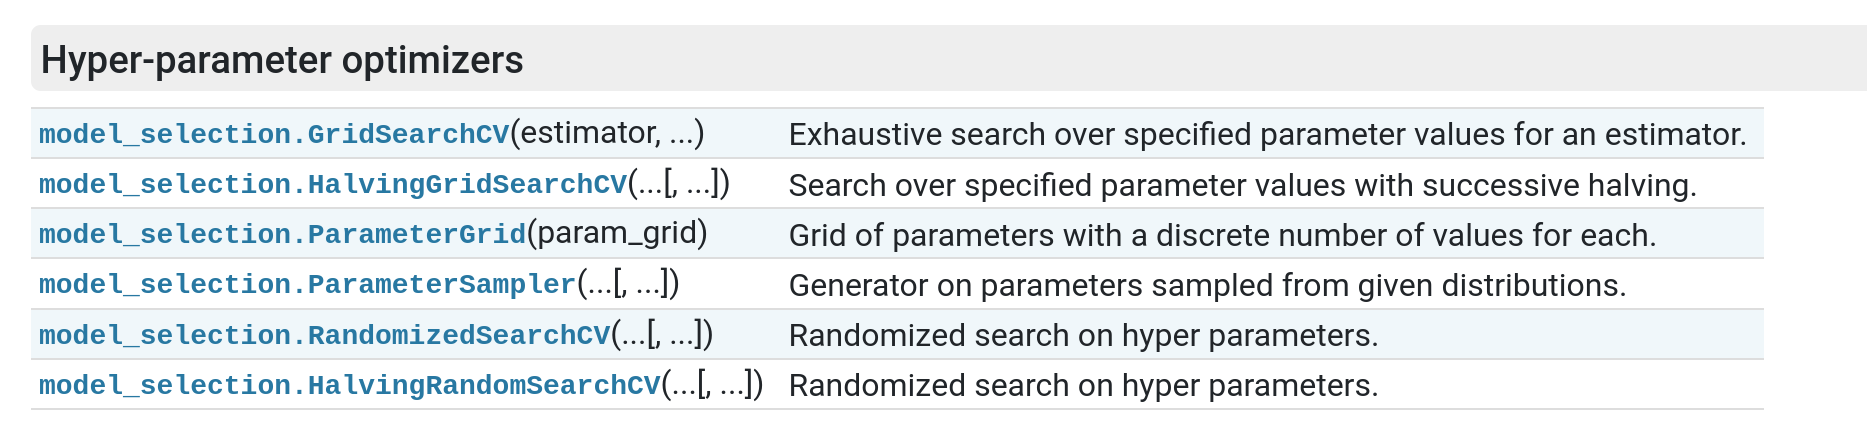

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

## ¿Cuál fue el mejor algoritmo que funcionó para sus datos?

## ¿Por qué cree que fue el que mejor funcionó?
## ¿Qué otras técnicas cree que puede utilizar para mejorar su algoritmo?

## ¿Los métodos aplicados le ayudaron a responder sus preguntas con base en los datos? Trate de mostrar gráficamente la información extraida del proceso.
## ¿Le hicieron falta datos?, realice una conjetura sobre como podría obtener mejores resultados.